## LSTM - Sineand Tan Wave Classification

Here, we'll use LSTM to classify the Sine series and Tangent series, considering them as the time-series.

**Step 1 : Importing the Libraries**

In [16]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

**Step 2 : Loading or Formulating the dataset**

Here we need to create the random series of both Sine and Tangent. **Sine** would be labeld as **0** and **Tangent** series would be **1**.

The structure of the dataset would be

| X   | y   |
| :---: | :--:|
| $[sin(a), sin(a+1), sin(a+2)..., sin(a+n)]$ | 0 |
| $[tan(a), tan(a+1), tan(a+2)..., tan(a+n)]$ | 1 |
| $[sin(b), sin(b+1), sin(b+2)..., sin(b+n)]$ | 0 |
| $[tan(b), tan(b+1), tan(b+2)..., tan(b+n)]$ | 1 |
| $... ... ... ... ...$  | ... |
| $[sin(z), sin(z+1), sin(z+2)..., sin(z+n)]$ | 0 |
| $[tan(z), tan(z+1), tan(z+2)..., tan(z+n)]$ | 1 |

$a ... z$ are the random number between $0 - 100.$<br/>
$n$ is the maximum data points we need. Here we choose it to be 400.<br/>
The rows in the dataset let's say would be $1000$. $500$ for $sin(x)$ and $500$ for $tan(x)$



In [3]:

main_series = []

for _ in range(0,1000):

    rn = np.random.randint(0,100)

    series_1 = []
    series_2 = []

    for i in range(rn,rn+400):
        series_1.append(np.sin(i) + 1) # +1 is there to make the sine's output positive by moving the sine series up by 1 unit
        series_2.append(np.abs(np.tan(i))) # abs is to get the absolute value of the Tan series to keep it positive

    main_series.append((series_1,0))
    main_series.append((series_2,1))

df = pd.DataFrame(main_series, columns=['X','y'])


**Step 2: Train-Test Split**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size = 0.20, random_state=42)

**Step 3 : Data Preprocessing**

The output from this would be series, so converting the values to list 

In [ ]:
X_train = list(X_train)
X_test = list(X_test)
y_train = list(y_train)
y_test = list(y_test)

Converting the values to the Tensors

In [7]:
x_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

**Step 4 : Modelling**

This part is most important so let's understand this properly.

<hr/>

### Network Initialization

<u>**Input-Output**</u>

Let's talk about input and output of the model first. <br/>

From **Step : 2** we have that the dataset is of $1000$ rows with each row of series length $400$. Therefore, the `self.input_layer_size` will be $400$.

<hr/>

<u>**Hidden Layer**</u>

So the hidden layer could have any number of value. We would need to tweak this value to see when the model performs the best. For now, let's keep this value as $200$.

<hr/>

<u>**LSTM Layer**</u>

As per the parameters defined above the *LSTM* layer would be like :

`self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size)` or ` self.lstm = nn.LSTM(400, 200)`

<hr/>

<u>**Fully Connected Layer**</u>

Now as the output of the *LSTM* layer is $200$, the input of the *Fully Conected* layer, which comes after the *LSTM* layer, should have to be $200$ as well. That is `self.hidden_layer_size` would be $200$.

The output of the *Fully Conected* layer depends upon the number of classes we have in the dataset. For now we have 2 classes, $0$ and $1$. This problem therefore is a *"Binary Classification"* problem. This would require the output of the network to be either $0$ or $1$. That is `self.output_layer_size` would be $1$

This can be achieved by setting the output of the *Fully Conected* as $1$.

So, as per the parameters defined above the *Fully Conected* layer would be like : 

`self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)` or `self.fc = nn.Linear(200, 1)`

<hr/>

<u>**Hidden Cell**</u>

We know that the *LSTM* cell have two more inputs apart from the data. They are called Hidden State Tensor $h_t$ and Cell State Tensor $c_t$. The dimensions of both $h_t$ and $c_t$ are same. 

Since the network need these as inputs so we need to pass them to the *LSTM* cell as well, although the network doesn't care what the initial values/states of $h_t$ and $c_t$ are, so we initialize them with $0$ Tensor.

Dimension of both $h_t$ and $c_t$ would be : (*number of LSTM layers*, *batch size*, *hidden layer size*)

In our case we have :

*number of LSTM layers* : $1$<br/>
*batch size* : $1$<br/>
*hidden layer size* : $200$

So, the Tensor value for $h_t$ would be = `torch.zeros(1,1,self.hidden_layer_size)`<br/>
the Tensor value for $c_t$ would be = `torch.zeros(1,1,self.hidden_layer_size)`

Here, `self.hidden_cell` is a touple having both `(h_t, c_t)`

<hr/>

<u>**Sigmoid Activation**</u>

Since this is a *Binary Classification Problem* we would need to keep the output of the network between $0$ and $1$ therefor we use the *Sigmoid Activation Function* on the output of the *Fully Connected Layer*. This is the defination of the function : `self.sigmoid = nn.Sigmoid()`

<hr/>

### Forward Function

This is where we'll use the above definations of the layers. This *Forward* function is the one which takes the input during the training of the phase or the prediction phase of the model. In our case, the input to this function `input_seq` is basically one of the following series :

$[sin(a), sin(a+1), sin(a+2)..., sin(a+n)]$  for $n=400$

$[tan(a), tan(a+1), tan(a+2)..., tan(a+n)]$ for $n=400$

<hr/>

<u>**LSTM Initialization**</u>

Since the incomming series is of dimension [1 x 400] or [400] which is a single dimensional tensor, we would need to convert it into 3 dimensional tensor i.e. [1,1,400]. This could be done as follows :

`input_seq.view(1 ,1, -1)`

This converted series will then have to be passed to *LSTM* layer's input. Also, we discussed above that the *LSTM Layer* also takes the hidden and cell state $h_t$ and $c_t$ as input. We would need to pass it as well during the layer's initialization along with the 3 dimensional series. This is done as follows:

`self.lstm(input_seq.view(1 ,1, -1), self.hidden_cell)`


In [10]:
class LSTMModule(nn.Module):

    def __init__(self):
        super(LSTMModule, self).__init__()

        self.input_layer_size = 400
        self.hidden_layer_size = 200
        self.output_layer_size = 1

        self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size)
        self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device), torch.zeros(1,1,self.hidden_layer_size).to(device))

        self.sigmoid = nn.Sigmoid()

    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(1 ,1, -1), self.hidden_cell)
        predictions = self.sigmoid(self.fc(lstm_out.view(1, -1)))
        return predictions[-1]

Defining Loss function and Optimizer for the model training. 

***Loss Function** -> BCE Loss since this is a binarry classification and we have only two classes*<br/>
***Optimizer** -> ADAM*

In [11]:
model = LSTMModule().to(device)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
print(model)

LSTMModule(
  (lstm): LSTM(400, 200)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**Step 5 : Model Training**

In [13]:
epochs = 10

running_loss_history = []
epoch_list = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model.train()

for i in range(epochs):

    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    running_loss = 0.0

    for seq, labels in zip(x_train, y_train):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, 200).to(device), torch.zeros(1, 1, 200).to(device))

        y_pred = model(seq)


        single_loss = criterion(y_pred, labels.unsqueeze(0).float())
        single_loss.backward()
        optimizer.step()

        preds = torch.round(y_pred).to(int).squeeze(0)
        running_corrects += torch.sum(preds == labels)

        running_loss += single_loss.item()


    else:
        with torch.no_grad():
            for val_inputs, val_labels in zip(x_test, y_test):

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels.unsqueeze(0).float())
                
                val_preds = torch.round(val_outputs).to(int).squeeze(0)

                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels)

        
    epoch_loss = running_loss/len(x_train)
    epoch_acc = running_corrects.float()/ len(x_train)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_acc = val_running_corrects.float()/ len(x_test)
    val_epoch_loss = val_running_loss/ len(x_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    epoch_list.append(i + 1)

    print("Epoch : ",i + 1)
    print('training loss: {:.4f}, acc {:.4f} '.format(running_loss/len(x_train), epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    print('_'*20)
    

Epoch :  1
training loss: 0.2767, acc 0.9131 
validation loss: 0.2865, validation acc 0.8825 
____________________
Epoch :  2
training loss: 0.0865, acc 0.9962 
validation loss: 0.2325, validation acc 0.9075 
____________________
Epoch :  3
training loss: 0.0369, acc 1.0000 
validation loss: 0.2364, validation acc 0.9000 
____________________
Epoch :  4
training loss: 0.0186, acc 1.0000 
validation loss: 0.2535, validation acc 0.8950 
____________________
Epoch :  5
training loss: 0.0096, acc 1.0000 
validation loss: 0.2719, validation acc 0.8850 
____________________
Epoch :  6
training loss: 0.0052, acc 1.0000 
validation loss: 0.2971, validation acc 0.8825 
____________________
Epoch :  7
training loss: 0.0029, acc 1.0000 
validation loss: 0.3263, validation acc 0.8775 
____________________
Epoch :  8
training loss: 0.0017, acc 1.0000 
validation loss: 0.3580, validation acc 0.8775 
____________________
Epoch :  9
training loss: 0.0010, acc 1.0000 
validation loss: 0.3915, validatio

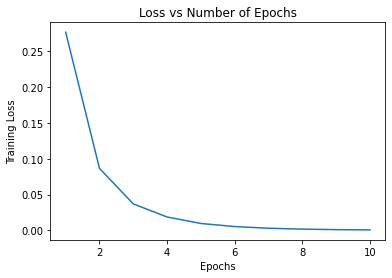

In [15]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

**Step 6 : Evaluating the Model**

Text(69.0, 0.5, 'Predicted Values')

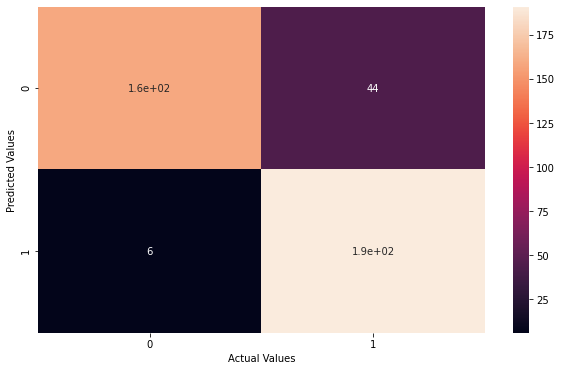

In [28]:
predictions=[]

with torch.no_grad():
        model.eval()

        for inputs, labels in zip(x_test, y_test):

                output = model(inputs)          
                predictions.append(torch.round(output).to(int).squeeze(0).to('cpu').item())
        
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.to('cpu').numpy(),predictions)
cm

plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [35]:
a = torch.zeros(400)
a.view(1 ,1, -1).shape

torch.Size([1, 1, 400])